In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader, Subset, ConcatDataset

from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix


import seaborn as sns
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True



In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Optional: Use subset (e.g., 30k)
subset_indices = list(range(30000))
train_set = Subset(train_set, subset_indices)

test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)


In [4]:
class ResNetWrapper(nn.Module):
    def __init__(self):
        super(ResNetWrapper, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

model = ResNetWrapper()
model = nn.DataParallel(model)  # Distributes across all GPUs
model = model.to(device)


/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
initial_size = int(0.05 * len(train_set))  # 5%
all_indices = list(range(len(train_set)))
initial_idx = random.sample(all_indices, initial_size)

labeled_set = Subset(train_set, initial_idx)
unlabeled_indices = list(set(all_indices) - set(initial_idx))
unlabeled_set = Subset(train_set, unlabeled_indices)

labeled_loader = DataLoader(labeled_set, batch_size=1000, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True, drop_last=True) 


In [6]:
def train(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def predict_probabilities(model, dataloader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu())
    return torch.cat(all_probs).numpy()


In [9]:
def evaluate_explanation(model, images, target_layers, device):
    model.eval()
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    
    images = images.to(device)
    grayscale_cams = cam(input_tensor=images, eigen_smooth=True)  # smooth for stability

    compactness_scores = []
    coherence_scores = []

    for cam_map in grayscale_cams:
        cam_map = cam_map.astype(np.float32)
        cam_map /= np.max(cam_map) + 1e-8  # normalize to [0,1]
        
        compactness = np.sum(cam_map > 0.3) / cam_map.size  # relaxed threshold
        coherence = np.std(cam_map)

        compactness_scores.append(compactness)
        coherence_scores.append(coherence)

    return np.mean(compactness_scores), np.mean(coherence_scores)



def plot_confusion_matrix(conf_matrix, class_names, strategy, iteration):
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({strategy.capitalize()} - Iteration {iteration})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_iterations = 8
budget_per_iter = 1000

performance_log = {'random': [], 'entropy': []}
selected_indices_random = []
selected_indices_entropy = []
explanation_log = {'random': [], 'entropy': []}
conf_matrix_log = {'random': [], 'entropy': []}


for strategy in ['random', 'entropy']:
    print(f"\n===== Starting AL with {strategy} sampling =====")

    # Reset model
    model = ResNetWrapper()
    model = nn.DataParallel(model)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    labeled_idx = initial_idx.copy()
    unlabeled_idx = list(set(all_indices) - set(labeled_idx))

    for it in range(num_iterations):
        print(f"\n--- Iteration {it+1}/{num_iterations} ---")
        labeled_set = Subset(train_set, labeled_idx)
        labeled_loader = DataLoader(labeled_set, batch_size=1024, shuffle=True, num_workers=4)

        # Train
        train(model, labeled_loader, criterion, optimizer, epochs=3)

        # Evaluate
        preds, labels = [], []
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                preds.extend(out.argmax(1).cpu().numpy())
                labels.extend(y.cpu().numpy())

        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        cm = confusion_matrix(labels, preds)

        performance_log[strategy].append((len(labeled_idx), acc, f1))
        conf_matrix_log[strategy].append(cm)

        # ✅ Evaluate Explanation Quality
        # sample_indices = random.sample(range(len(labeled_set)), 32)
        # sample_images = torch.stack([labeled_set[i][0] for i in sample_indices])
        sample_loader = DataLoader(labeled_set, batch_size=32, shuffle=True)
        sample_images, _ = next(iter(sample_loader))
        target_layers = [model.module.model.layer4[-1]]

        compactness, coherence = evaluate_explanation(model, sample_images, target_layers, device)
        explanation_log[strategy].append((compactness, coherence))

        # Sampling
        unlabeled_set = Subset(train_set, unlabeled_idx)
        unlabeled_loader = DataLoader(unlabeled_set, batch_size=1024, shuffle=False, num_workers=4)

        probs = predict_probabilities(model, unlabeled_loader)

        if strategy == 'entropy':
            uncertainty = -np.sum(probs * np.log(probs + 1e-6), axis=1)
            query_idx = np.argsort(uncertainty)[-budget_per_iter:]
        else:
            query_idx = np.random.choice(len(unlabeled_idx), budget_per_iter, replace=False)

        # Convert query_idx to global index
        selected_global = [unlabeled_idx[i] for i in query_idx]
        labeled_idx.extend(selected_global)
        unlabeled_idx = list(set(unlabeled_idx) - set(selected_global))

        if strategy == 'entropy':
            selected_indices_entropy.append(selected_global)
        else:
            selected_indices_random.append(selected_global)



===== Starting AL with random sampling =====


/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Iteration 1/8 ---


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]



--- Iteration 2/8 ---


100%|██████████| 27/27 [00:07<00:00,  3.67it/s]



--- Iteration 3/8 ---


100%|██████████| 26/26 [00:08<00:00,  2.92it/s]



--- Iteration 4/8 ---


100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



--- Iteration 5/8 ---


100%|██████████| 24/24 [00:06<00:00,  3.65it/s]



--- Iteration 6/8 ---


100%|██████████| 23/23 [00:07<00:00,  3.16it/s]



--- Iteration 7/8 ---


100%|██████████| 22/22 [00:06<00:00,  3.55it/s]



--- Iteration 8/8 ---


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== Starting AL with entropy sampling =====

--- Iteration 1/8 ---


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]



--- Iteration 2/8 ---


100%|██████████| 27/27 [00:07<00:00,  3.85it/s]



--- Iteration 3/8 ---


100%|██████████| 26/26 [00:07<00:00,  3.66it/s]



--- Iteration 4/8 ---


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]



--- Iteration 5/8 ---


100%|██████████| 24/24 [00:06<00:00,  3.69it/s]



--- Iteration 6/8 ---


100%|██████████| 23/23 [00:08<00:00,  2.70it/s]



--- Iteration 7/8 ---


100%|██████████| 22/22 [00:07<00:00,  2.83it/s]



--- Iteration 8/8 ---


100%|██████████| 21/21 [00:05<00:00,  3.55it/s]


In [11]:
explanation_log 

{'random': [(0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0)],
 'entropy': [(0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0)]}

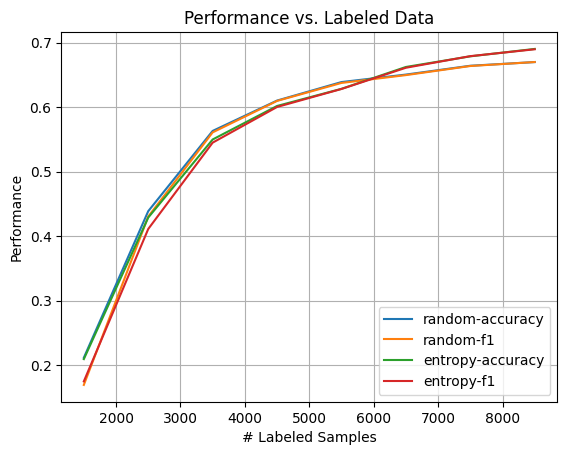

In [12]:
import matplotlib.pyplot as plt

def plot_performance(logs):
    for strategy in logs:
        samples = [x[0] for x in logs[strategy]]
        acc = [x[1] for x in logs[strategy]]
        f1 = [x[2] for x in logs[strategy]]

        plt.plot(samples, acc, label=f"{strategy}-accuracy")
        plt.plot(samples, f1, label=f"{strategy}-f1")
    plt.xlabel("# Labeled Samples")
    plt.ylabel("Performance")
    plt.title("Performance vs. Labeled Data")
    plt.legend()
    plt.grid()
    plt.show()

plot_performance(performance_log)


In [19]:
def samples_to_target(logs, threshold=0.80):
    for strategy in logs:
        for labeled, acc, _ in logs[strategy]:
            if acc >= threshold:
                print(f"{strategy} reached {threshold*100}% accuracy with {labeled} samples.")
                break

samples_to_target(performance_log, threshold=0.70)


In [14]:
def plot_explanation_metrics(explanation_log):
    for strategy in explanation_log:
        compactness = [x[0] for x in explanation_log[strategy]]
        coherence = [x[1] for x in explanation_log[strategy]]

        if max(compactness) - min(compactness) < 1e-3:  # flat line check
            print(f"[{strategy}] Compactness may be too flat. Try dynamic sampling or layer tuning.")
        if max(coherence) - min(coherence) < 1e-3:
            print(f"[{strategy}] Coherence may be too flat.")

        plt.plot(compactness, label=f"{strategy} compactness", linestyle='--', marker='o')
        plt.plot(coherence, label=f"{strategy} coherence", linestyle='-', marker='x')

    plt.xlabel("AL Iteration")
    plt.ylabel("Explanation Metric (Normalized)")
    plt.title("Explainability over AL iterations")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


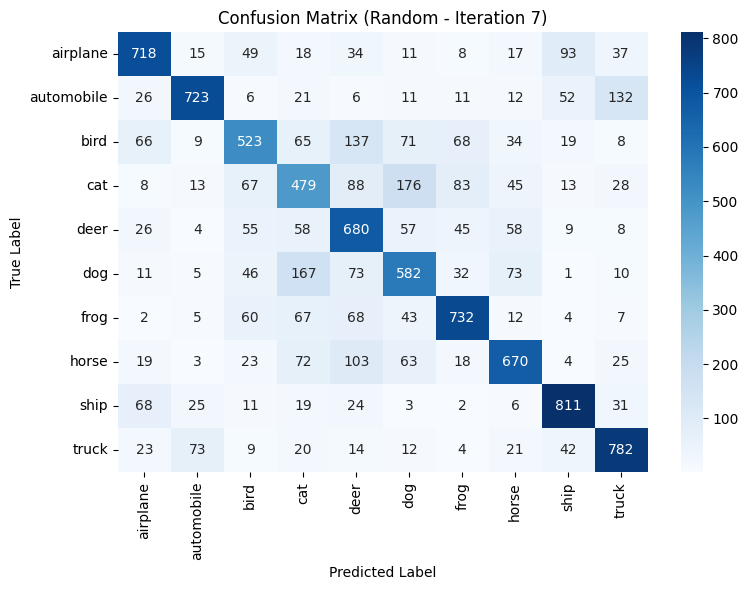

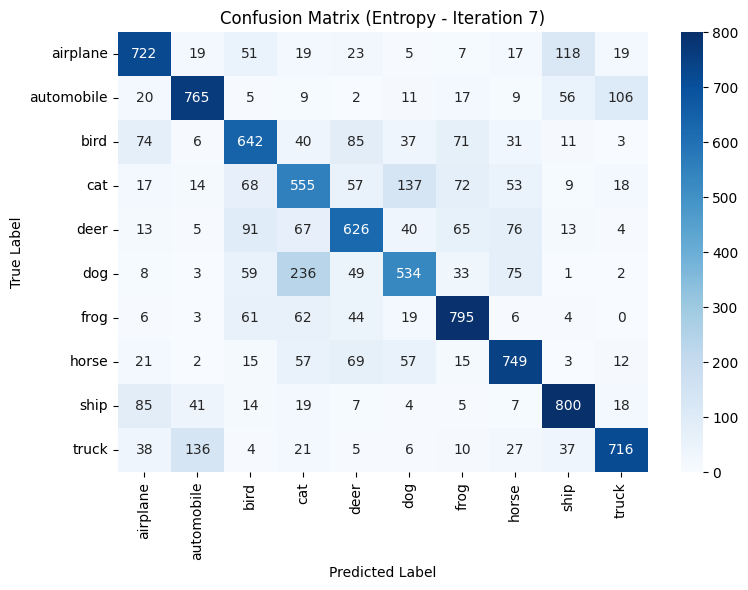

In [15]:
class_names = test_set.classes  # For CIFAR-10

# Final confusion matrix (last iteration)
for strategy in conf_matrix_log:
    final_cm = conf_matrix_log[strategy][-1]  # last matrix
    plot_confusion_matrix(final_cm, class_names, strategy, iteration=len(conf_matrix_log[strategy])-1)


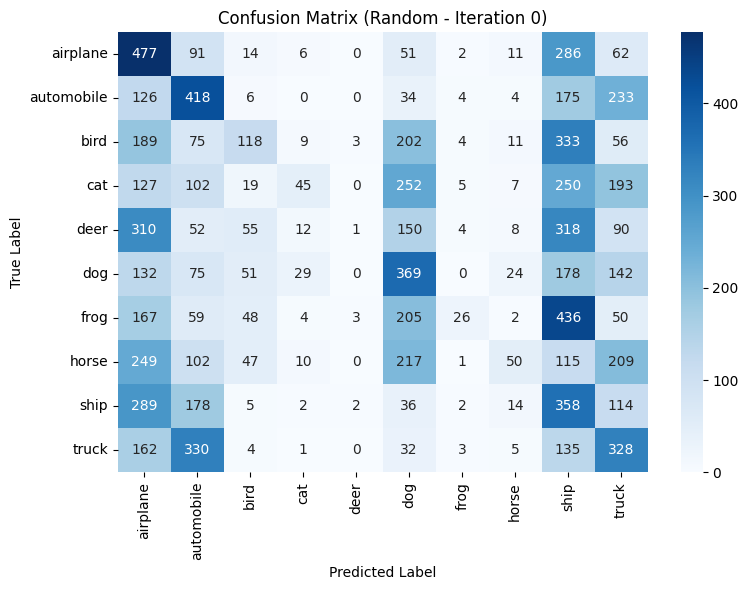

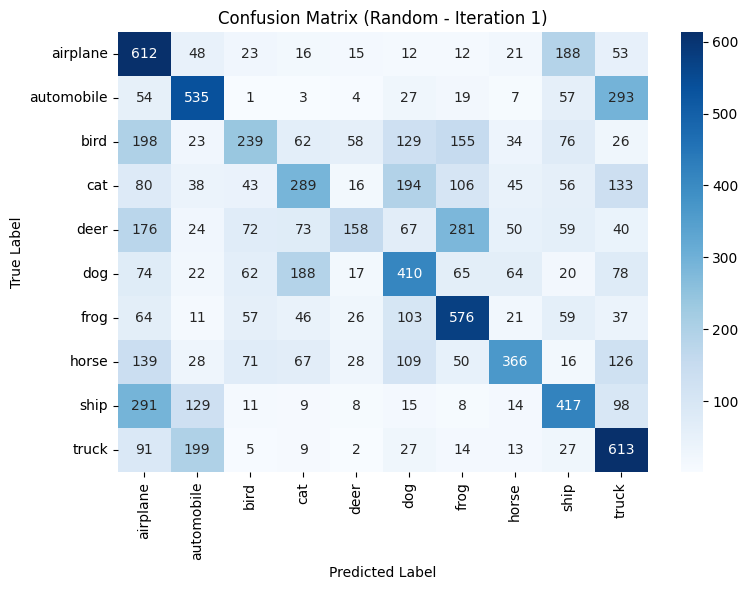

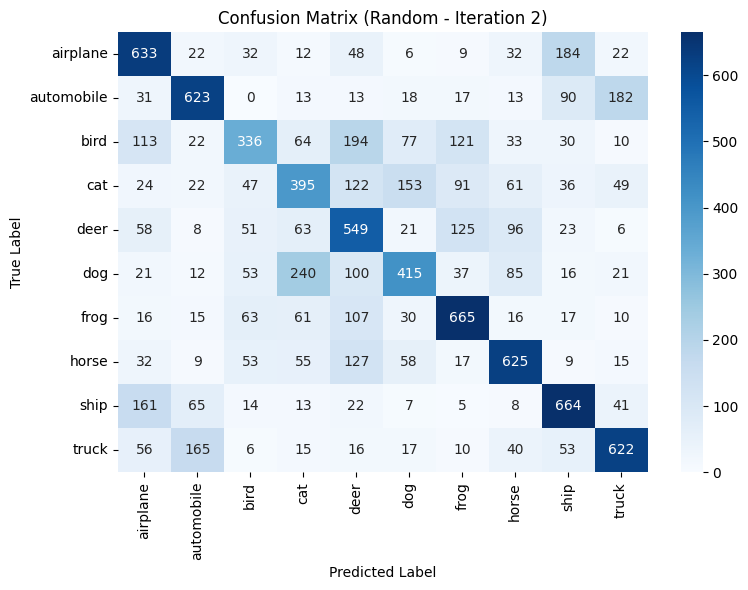

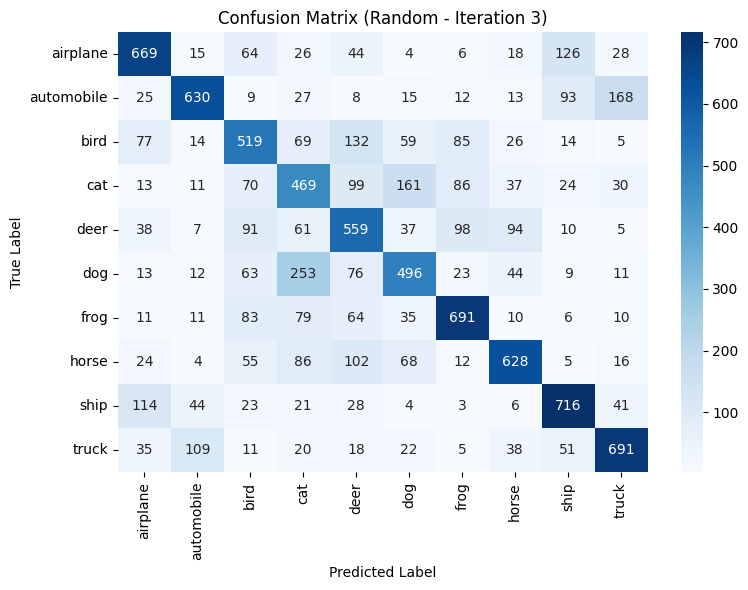

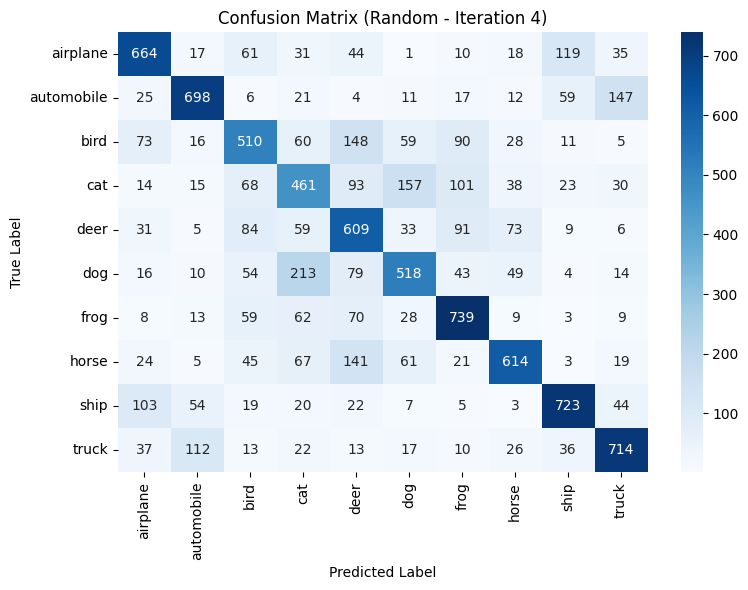

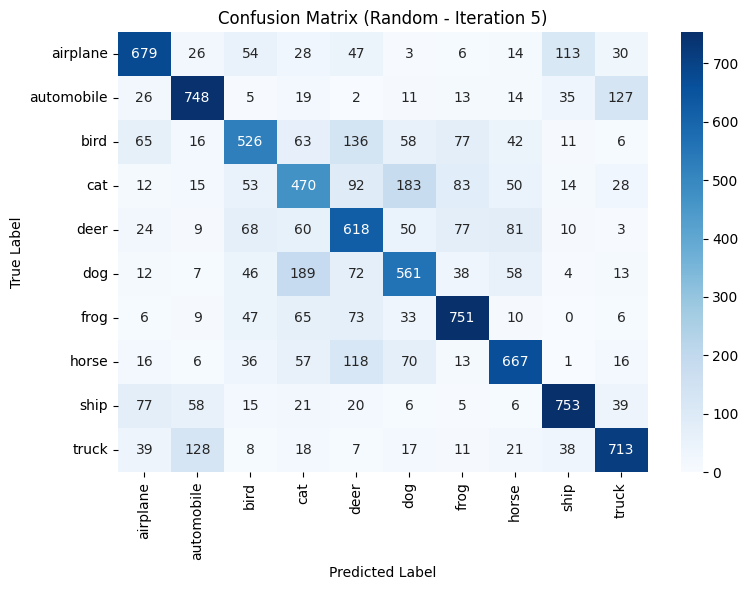

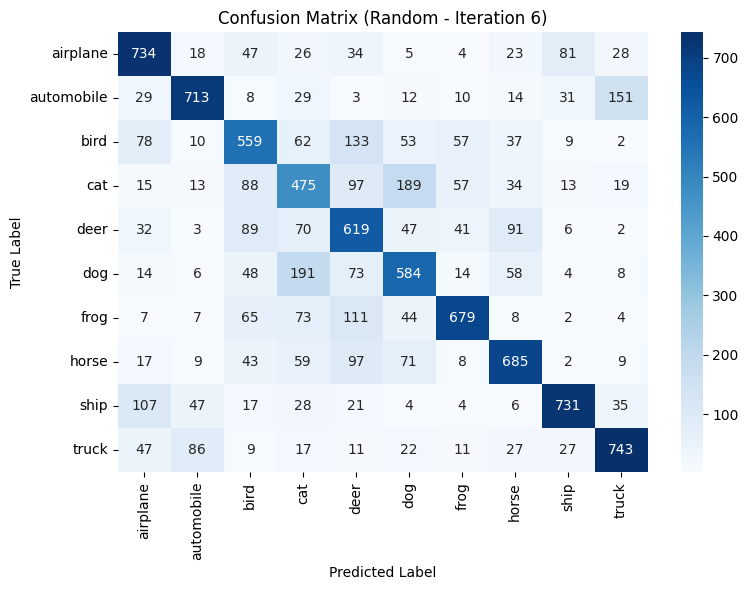

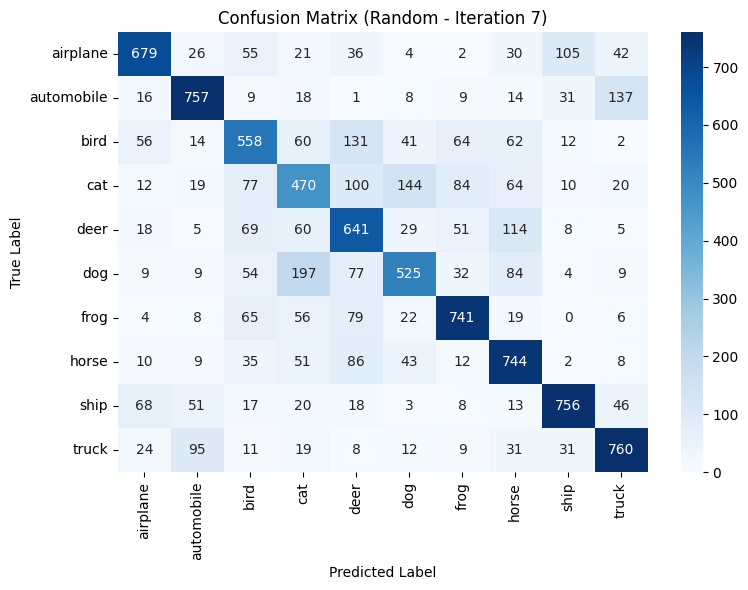

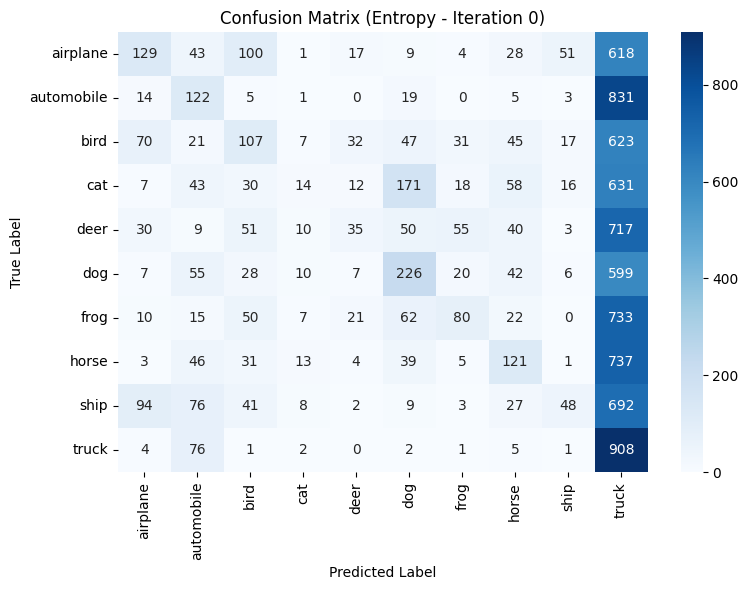

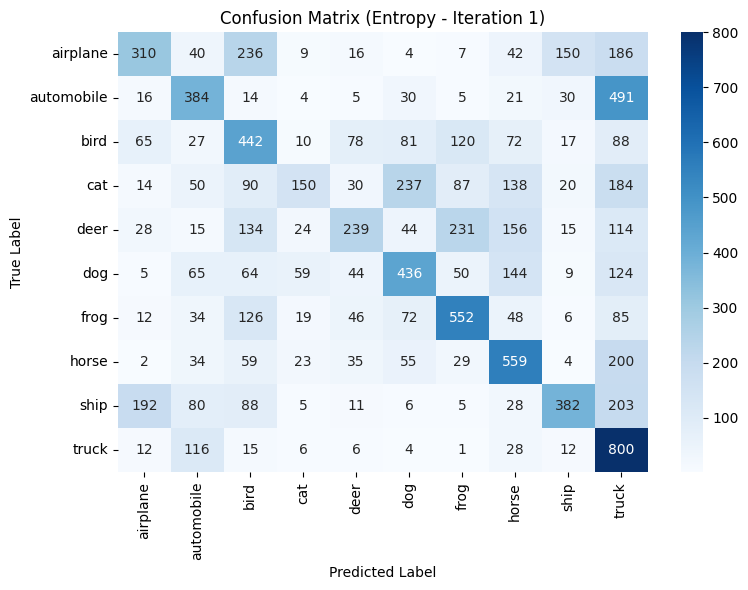

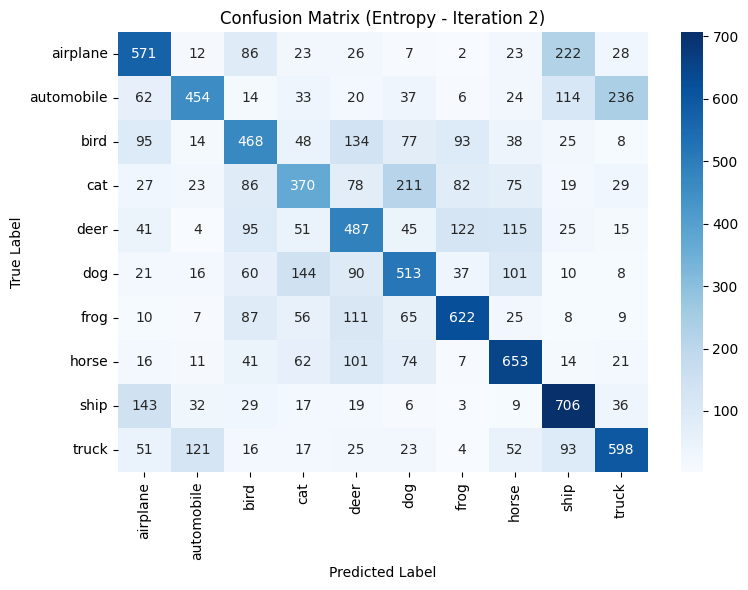

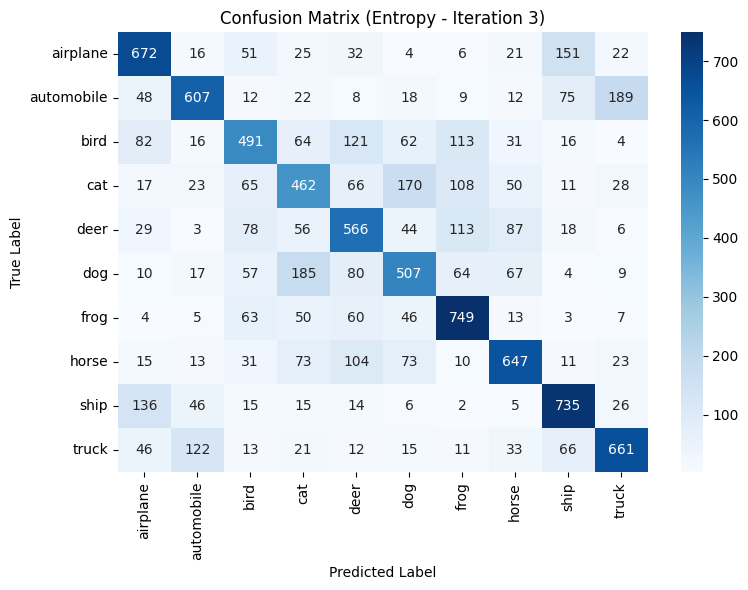

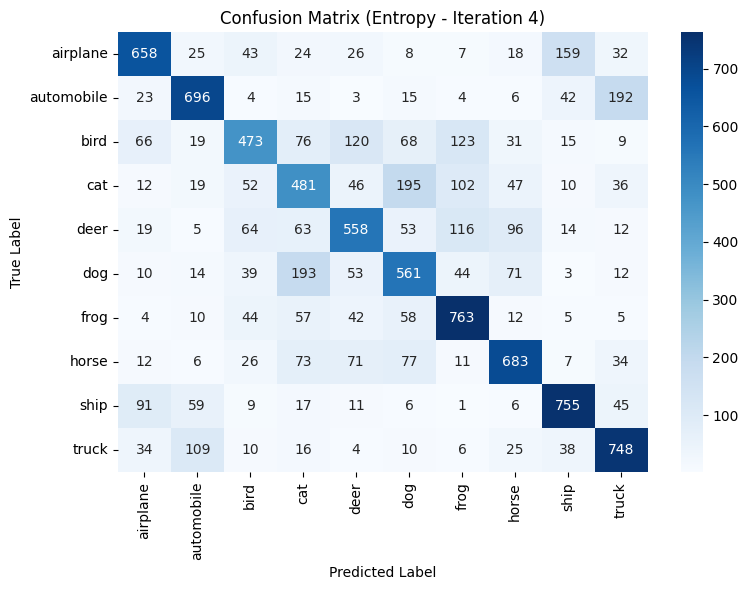

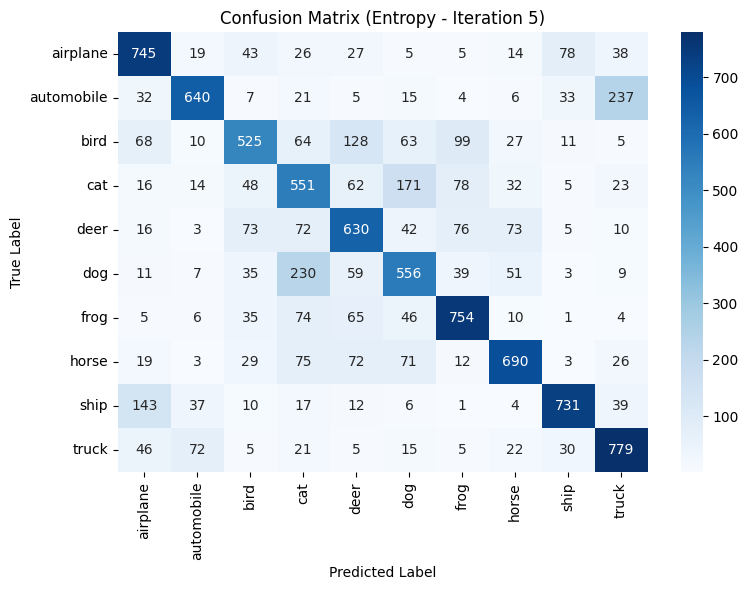

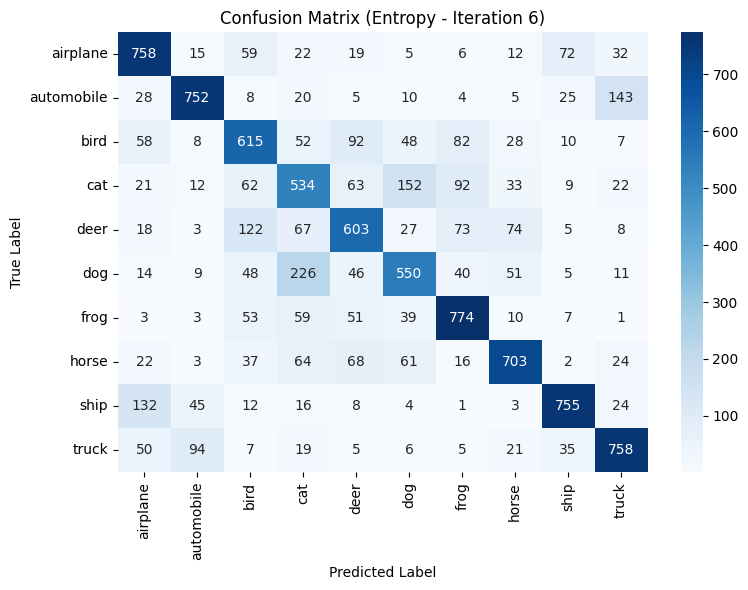

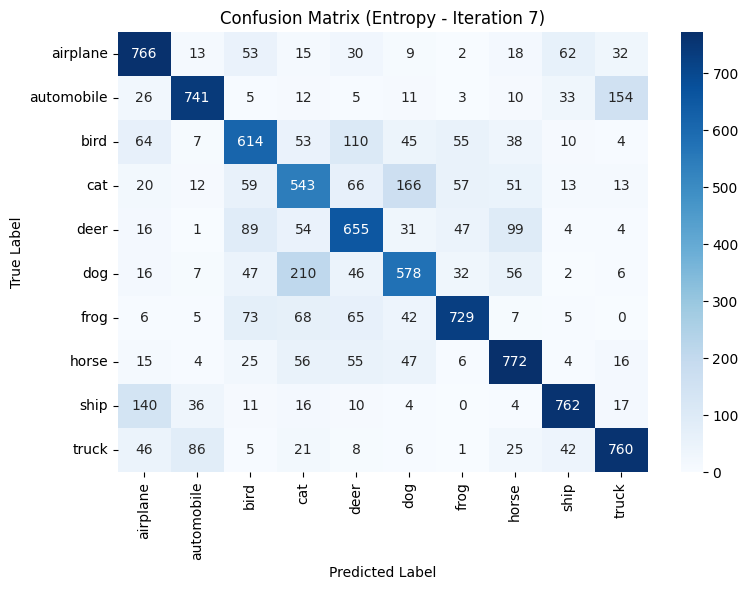

In [20]:
for strategy in conf_matrix_log:
    for i, cm in enumerate(conf_matrix_log[strategy]):
        plot_confusion_matrix(cm, class_names, strategy, i)


Metric/Question | Covered in Code? | Where?
1. Are entropy samples harder to explain? | ✅ | evaluate_explanation() metrics
2. Accuracy, F1, Confusion Matrix | ✅ | performance_log, conf_matrix_log
3. Entropy vs. Random Efficiency | ✅ | samples_to_target(), plots
4. Labeled Samples vs. Performance | ✅ | plot_performance()
5. Sample Efficiency | ✅ | samples_to_target()